In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:1


In [3]:
! ls /data/sg/ashutiwa/final_128/airport/airport_one/

airport_adj_crosswalk.npz
airport_adj_fairwalk.npz
airport_adj.npz
airport_crosswalk_deepwalk.npy
airport_crosswalk_node2vec.npy
airport_deepwalk_128_embs.npy
airport_deepwalk.npy
airport_fairwalk_deepwalk.npy
airport_fairwalk_node2vec.npy
airport_gat_None_deepwalk_deepwalk_embs.npy
airport_gat_None_deepwalk_deepwalk.h5
airport_gat_None_deepwalk_r2v_embs.npy
airport_gat_None_deepwalk_r2v.h5
airport_gat_None_node2vec_deepwalk_embs.npy
airport_gat_None_node2vec_deepwalk.h5
airport_gat_None_node2vec_r2v_embs.npy
airport_gat_None_node2vec_r2v.h5
airport_gcn_None_deepwalk_deepwalk_embs.npy
airport_gcn_None_deepwalk_deepwalk.h5
airport_gcn_None_deepwalk_r2v_embs.npy
airport_gcn_None_deepwalk_r2v.h5
airport_gcn_None_node2vec_deepwalk_embs.npy
airport_gcn_None_node2vec_deepwalk.h5
airport_gcn_None_node2vec_r2v_embs.npy
airport_gcn_None_node2vec_r2v.h5
airport_node2vec_128_embs.npy
airport_node2vec.npy
airport_residual2vec_128_embs.npy
airport_test_adj.npz


In [4]:
y = snakemake_utils.get_dataset("polblog").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_128/polblog/'

DIRS = ['polblog_one/', 'polblog_two/', 'polblog_three/', 'polblog_four/', 'polblog_five/']
DATASET = 'polblog'
model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    "deepwalk": "_deepwalk_128_embs.npy",
    "node2vec": "_node2vec_128_embs.npy",
    "residual2vec": "_residual2vec_128_embs.npy"
    
    
}
M = list(model_to_embs.keys())


TEST_ADJ_FILE='/data/sg/ashutiwa/final_128/polblog/polblog_one/polblog_test_adj.npz'
NUM_NODES=1224
k=5

# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# residual2vec

In [8]:
model = "residual2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


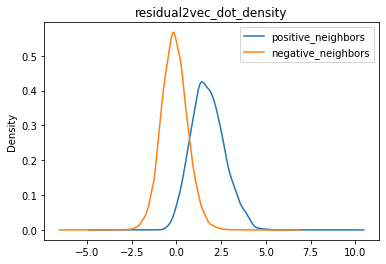

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5469.16it/s]


((6120, 2), 0.0029541647010621506, 0.9473939512334035, 0.2149547883031558)

# deepwalk

In [11]:
model = "deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


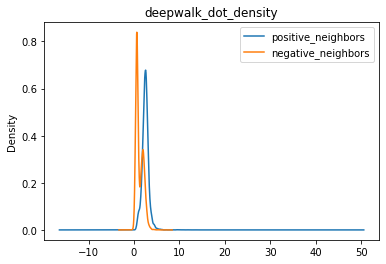

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6036.11it/s]


((6112, 2), 0.004956094786521469, 0.8822563329995595, 0.30132596419802865)

# node2vec

In [14]:
model = "node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


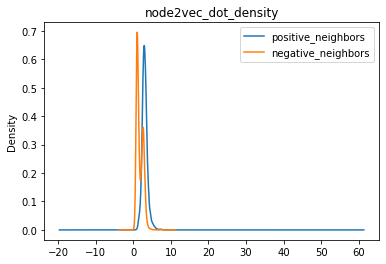

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4958.38it/s]


((6116, 2), 0.004734857945287709, 0.8741431168713848, 0.2924705071451723)

# fairwalk+deepwalk

In [17]:
model = "fairwalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


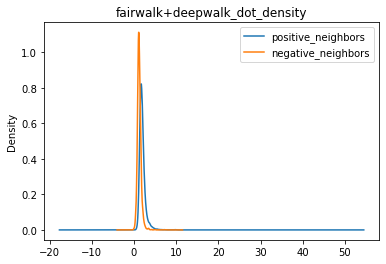

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4825.59it/s]


((6114, 2), 0.003443149281223132, 0.8575617203973819, 0.22447693976928848)

# fairwalk+node2vec

In [20]:
model = "fairwalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12171


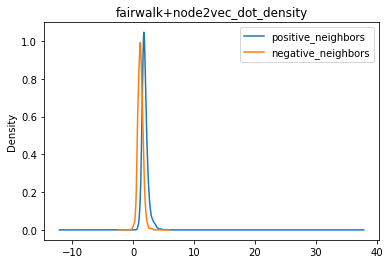

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5802.30it/s]


((6116, 2), 0.003994585615376474, 0.8880825540028521, 0.25938998412151676)

# crosswalk+deepwalk

In [23]:
model = "crosswalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


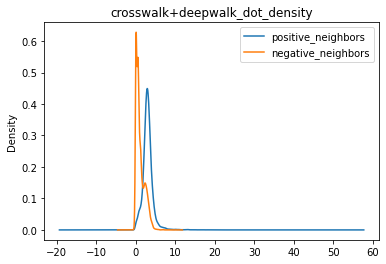

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6063.43it/s]


((6114, 2), 0.004557974748959038, 0.8804366941515848, 0.30408954360685503)

# crosswalk+node2vec

In [26]:
model = "crosswalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


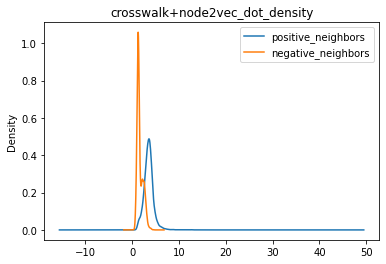

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6241.83it/s]


((6108, 2), 0.004675220842617046, 0.9444039774975287, 0.30427729406749404)

# GCN+deepwalk+random

In [29]:
model = "GCN+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


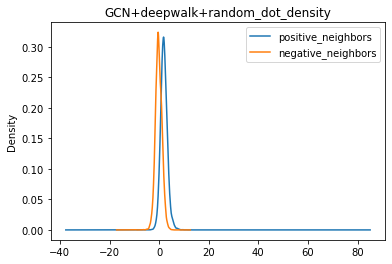

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6457.17it/s]


((6120, 2), 0.004379452741324555, 0.873943401400365, 0.2957796607206669)

# GCN+deepwalk+r2v

In [32]:
model = "GCN+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12171


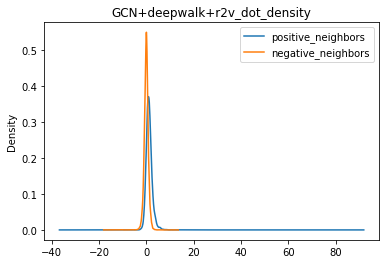

In [33]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [34]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6322.34it/s]


((6120, 2), 0.003370704097847859, 0.8009896880606292, 0.24085810202622454)

# GCN+node2vec+random

In [35]:
model = "GCN+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


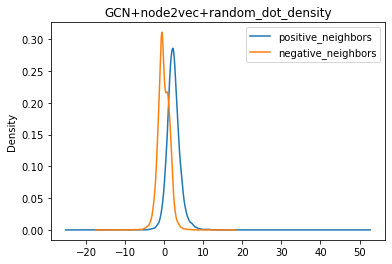

In [36]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [37]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6400.79it/s]


((6120, 2), 0.0046103998865677405, 0.881006414353683, 0.30527606665348583)

# GCN+node2vec+r2v

In [38]:
model = "GCN+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


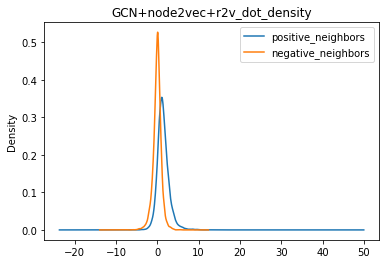

In [39]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [40]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6380.20it/s]


((6120, 2), 0.003555076809912127, 0.8166688630001689, 0.250035247065839)

# GAT+deepwalk+random

In [41]:
model = "GAT+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


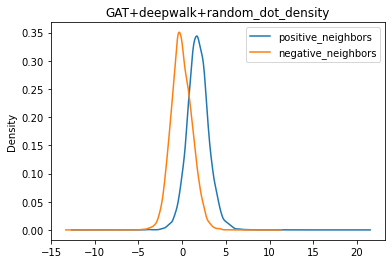

In [42]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [43]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5239.34it/s]


((6120, 2), 0.004346328522228405, 0.8651332282671111, 0.2987640900062508)

# GAT+deepwalk+r2v

In [44]:
model = "GAT+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


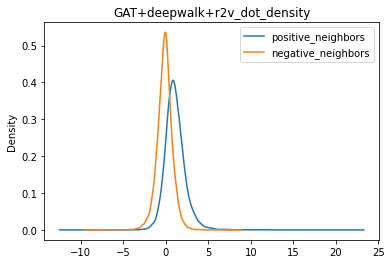

In [45]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [46]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5237.30it/s]


((6120, 2), 0.0032175348759620696, 0.8102764085206237, 0.23753266645167204)

# GAT+node2vec+random

In [47]:
model = "GAT+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


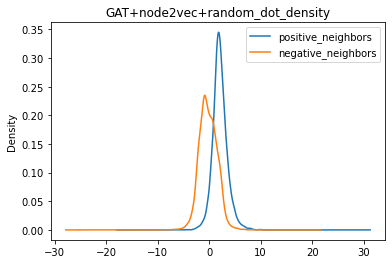

In [48]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [49]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6359.75it/s]


((6120, 2), 0.004548718449639859, 0.8504489886912014, 0.302184312387357)

# GAT+node2vec+r2v

In [50]:
model = "GAT+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


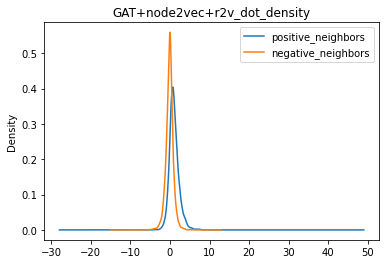

In [51]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [52]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6102.04it/s]


((6120, 2), 0.0034989319756193672, 0.7874080875608467, 0.2524453991378402)

# plot statistical parity scores

# gini sp scores

residual2vec 0.2149547883031558
deepwalk 0.30132596419802865
node2vec 0.2924705071451723
fairwalk+deepwalk 0.22447693976928848
fairwalk+node2vec 0.25938998412151676
crosswalk+deepwalk 0.30408954360685503
crosswalk+node2vec 0.30427729406749404
GCN+deepwalk+random 0.2957796607206669
GCN+deepwalk+r2v 0.24085810202622454
GCN+node2vec+random 0.30527606665348583
GCN+node2vec+r2v 0.250035247065839
GAT+deepwalk+random 0.2987640900062508
GAT+deepwalk+r2v 0.23753266645167204
GAT+node2vec+random 0.302184312387357
GAT+node2vec+r2v 0.2524453991378402


Text(0.5, 1.0, 'gini statistical parity scores')

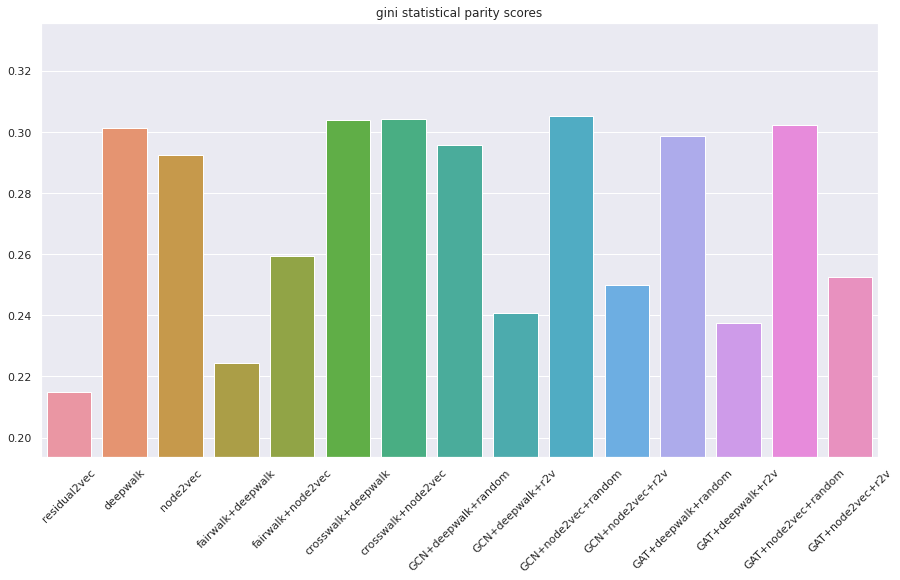

In [53]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

residual2vec 0.0029541647010621506
deepwalk 0.004956094786521469
node2vec 0.004734857945287709
fairwalk+deepwalk 0.003443149281223132
fairwalk+node2vec 0.003994585615376474
crosswalk+deepwalk 0.004557974748959038
crosswalk+node2vec 0.004675220842617046
GCN+deepwalk+random 0.004379452741324555
GCN+deepwalk+r2v 0.003370704097847859
GCN+node2vec+random 0.0046103998865677405
GCN+node2vec+r2v 0.003555076809912127
GAT+deepwalk+random 0.004346328522228405
GAT+deepwalk+r2v 0.0032175348759620696
GAT+node2vec+random 0.004548718449639859
GAT+node2vec+r2v 0.0034989319756193672


Text(0.5, 1.0, 'statistical parity scores')

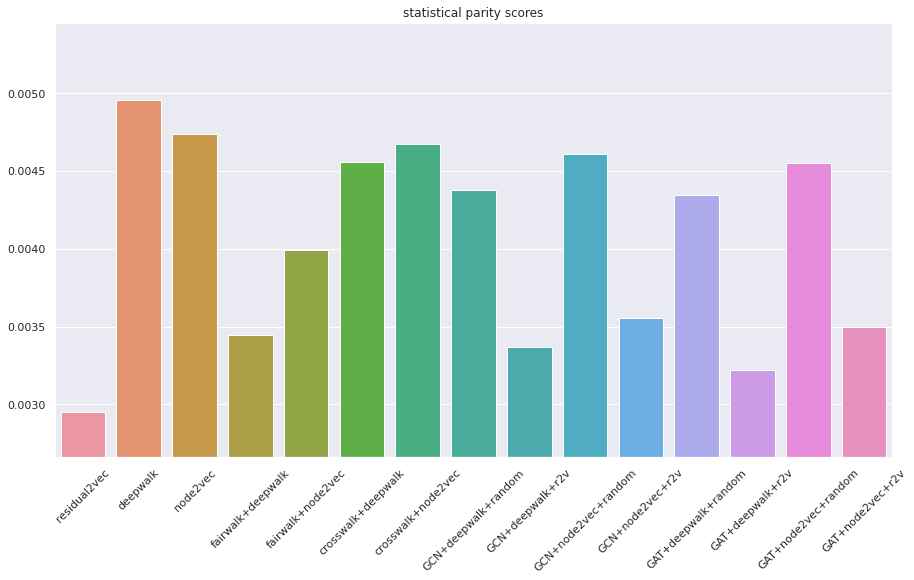

In [54]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

residual2vec 0.9473939512334035
deepwalk 0.8822563329995595
node2vec 0.8741431168713848
fairwalk+deepwalk 0.8575617203973819
fairwalk+node2vec 0.8880825540028521
crosswalk+deepwalk 0.8804366941515848
crosswalk+node2vec 0.9444039774975287
GCN+deepwalk+random 0.873943401400365
GCN+deepwalk+r2v 0.8009896880606292
GCN+node2vec+random 0.881006414353683
GCN+node2vec+r2v 0.8166688630001689
GAT+deepwalk+random 0.8651332282671111
GAT+deepwalk+r2v 0.8102764085206237
GAT+node2vec+random 0.8504489886912014
GAT+node2vec+r2v 0.7874080875608467


Text(0.5, 1.0, 'roc scores')

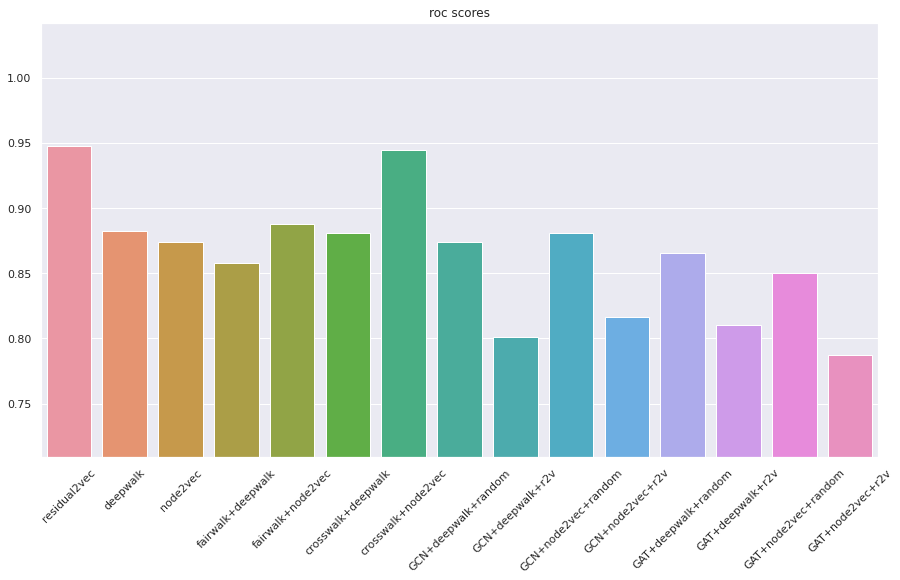

In [55]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [56]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4916.27it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5269.01it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5186.76it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5013.57it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6489.60it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5973.95it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4857.84it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5200.04it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5057.27it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5229.16it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5301.22it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6401.11it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6272.74it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6246.25it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6361.17it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6316.88it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6250.98it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 3693.13it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 3844.69it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6348.86it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6165.57it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6318.44it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6187.19it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6320.47it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6386.57it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6262.91it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4981.16it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4965.41it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5053.38it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6401.59it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6292.49it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4896.79it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5651.83it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6149.27it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6159.63it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6079.13it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6177.92it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6399.51it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

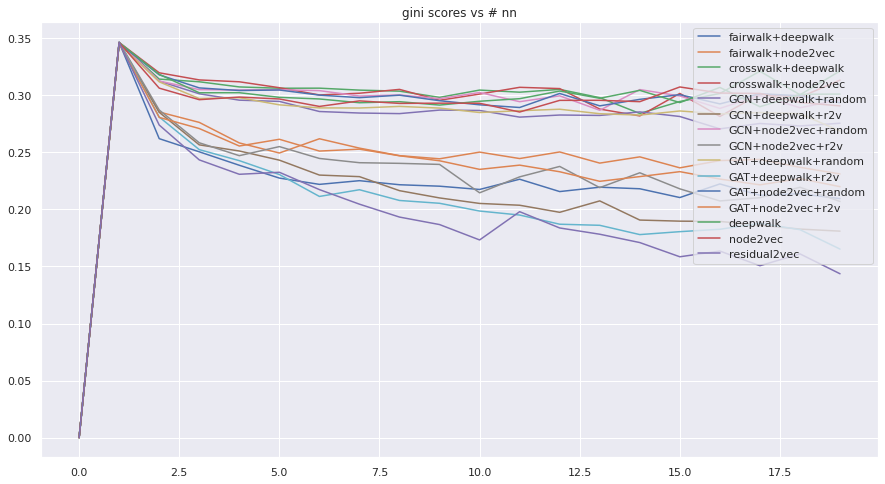

In [57]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

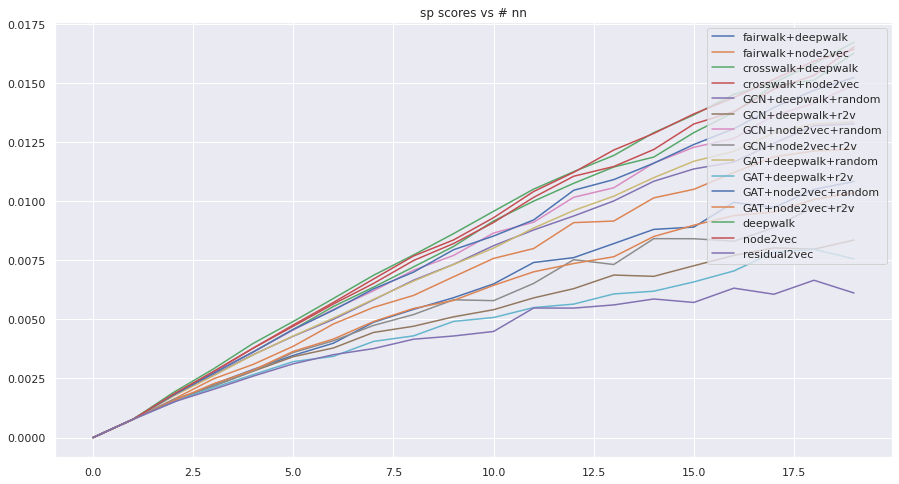

In [58]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [59]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, K, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected e

Text(0.5, 1.0, 'roc scores')

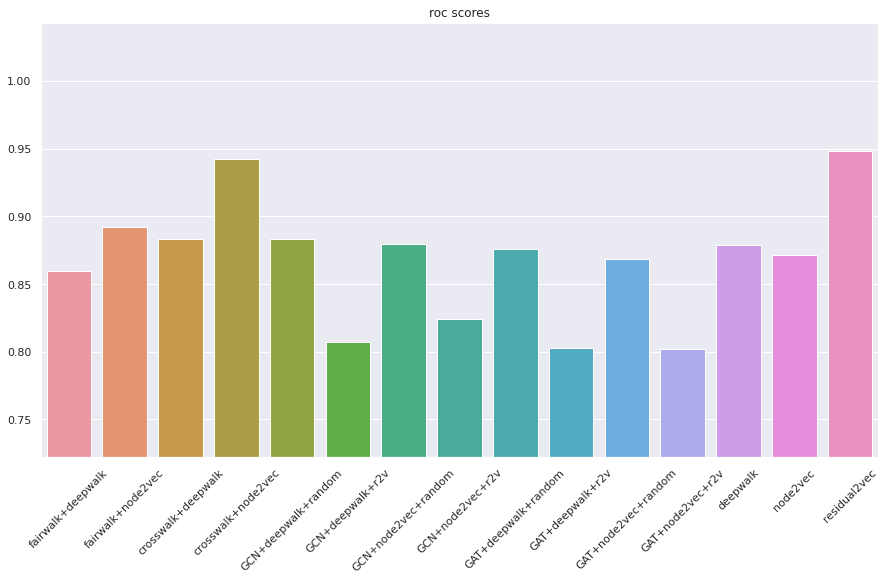

In [60]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6204.74it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6288.16it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6101.75it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5965.04it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6300.70it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6106.85it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6271.20it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6203.24it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6414.60it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4442.12it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5217.01it/s]
WARNING clustering 1224 points to 35 centroids: please 

fairwalk+deepwalk 0.0036979296932162023
fairwalk+node2vec 0.003981467957554108
crosswalk+deepwalk 0.004648140706616784
crosswalk+node2vec 0.0046765284233425105
GCN+deepwalk+random 0.004397546572535579
GCN+deepwalk+r2v 0.0032840232922082073
GCN+node2vec+random 0.004514231370352265
GCN+node2vec+r2v 0.0036207550319548405
GAT+deepwalk+random 0.004472433187603255
GAT+deepwalk+r2v 0.0030658924746663325
GAT+node2vec+random 0.004482226865245952
GAT+node2vec+r2v 0.0035966601096268425
deepwalk 0.004959848973370969
node2vec 0.0048237181085563265
residual2vec 0.003058988497186703


Text(0.5, 1.0, 'statistical parity scores')

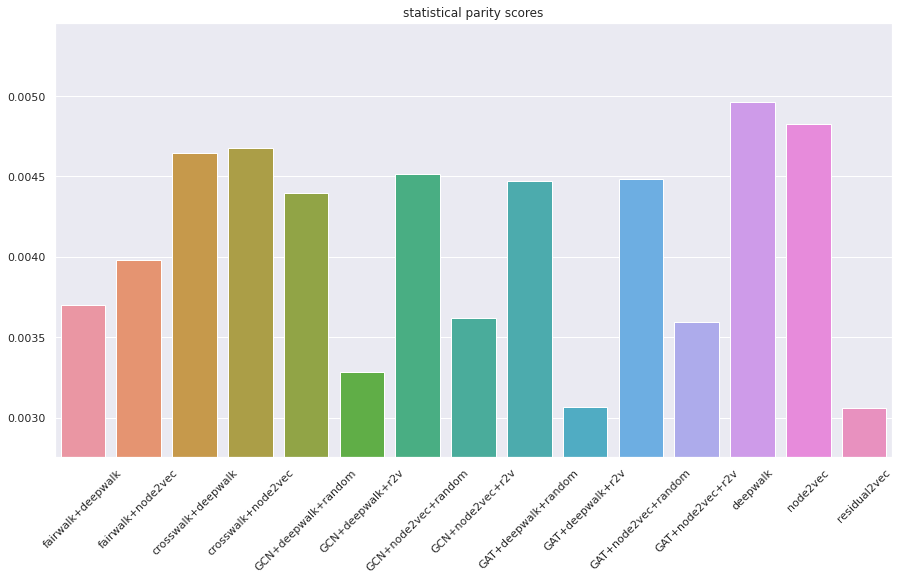

In [61]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.2399132791465267
fairwalk+node2vec 0.2627270341377792
crosswalk+deepwalk 0.3075695209521928
crosswalk+node2vec 0.30312688507748453
GCN+deepwalk+random 0.2989256809738504
GCN+deepwalk+r2v 0.23616302928667307
GCN+node2vec+random 0.30137220138591553
GCN+node2vec+r2v 0.2547395513336673
GAT+deepwalk+random 0.3042084895283746
GAT+deepwalk+r2v 0.22742695775244895
GAT+node2vec+random 0.30079214593969084
GAT+node2vec+r2v 0.2566881273437972
deepwalk 0.3006845692578931
node2vec 0.29414584328797966
residual2vec 0.22575122823071125


Text(0.5, 1.0, 'gini statistical parity scores')

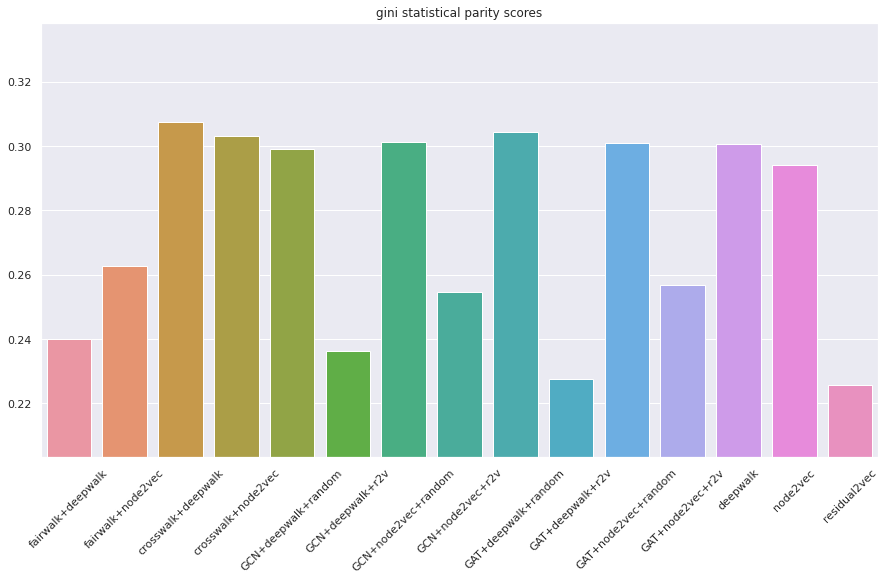

In [62]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [63]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected edge_idx size: 12938
selected edge_idx size: 13058
selected edge_idx size: 12171
selected edge_idx size: 13123
selected edge_idx size: 12149
selected e

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6146.90it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5578.99it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5542.13it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5478.64it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5498.19it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6279.36it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6019.92it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6455.22it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4133.32it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6456.36it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5316.97it/s]
WARNING clustering 1224 points to 35 centroids: please 